<a href="https://www.kaggle.com/code/mostafamamdouhhassan/yolov8-vs-yolov11-vehicle-detection?scriptVersionId=219336845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 16.1 MB/s eta 0:00:00


# Importing Needed Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

# Loading YOLO Models 


In [4]:
# YOLOV8
model_v8 = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 85.0MB/s]


In [5]:
# YOLOV11
model_v11 = YOLO("yolo11n.pt")  

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.6MB/s]


# Testing Models Before Finetuning


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 cars, 75.7ms
Speed: 9.1ms preprocess, 75.7ms inference, 266.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 cars, 25.3ms
Speed: 1.9ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


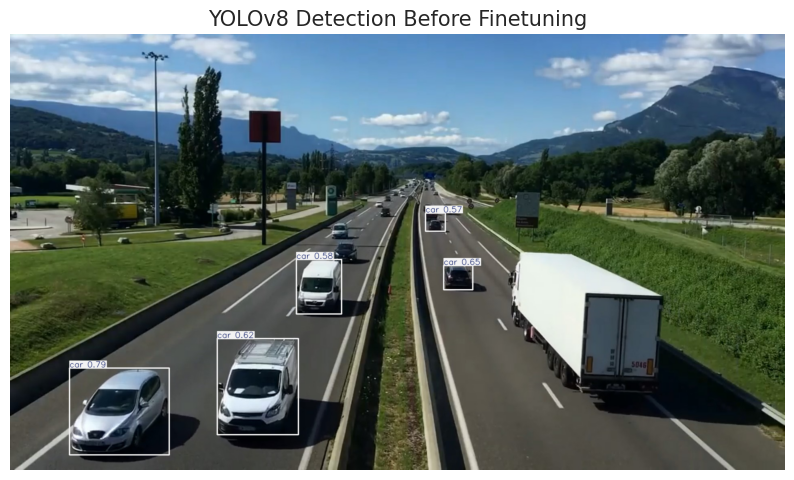

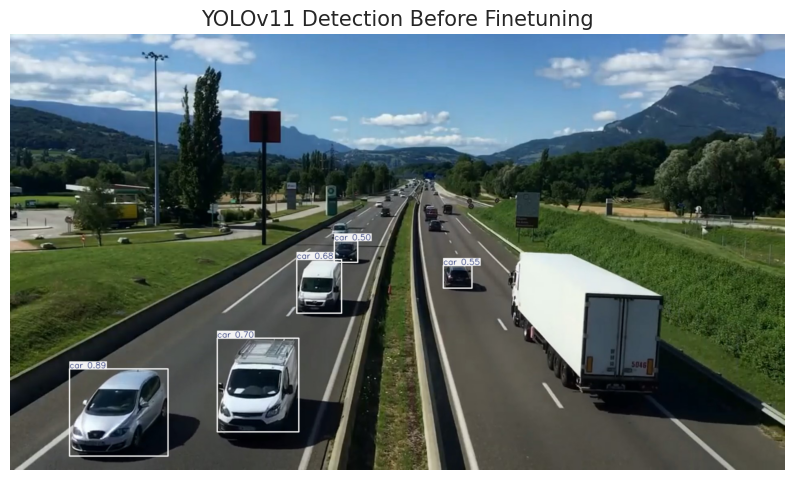

In [6]:
image_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg'

# Predict using YOLOv8
result_v8 = model_v8.predict(
    source=image_path, 
    imgsz=640,  
    conf=0.5
)

# Predict using YOLOv11
result_v11 = model_v11.predict(
    source=image_path, 
    imgsz=640,  
    conf=0.5
)

# Plot results from YOLOv8
sample_image_v8 = result_v8[0].plot(line_width=2)
sample_image_v8 = cv2.cvtColor(sample_image_v8, cv2.COLOR_BGR2RGB)

# Plot results from YOLOv11
sample_image_v11 = result_v11[0].plot(line_width=2)
sample_image_v11 = cv2.cvtColor(sample_image_v11, cv2.COLOR_BGR2RGB)

# Display the YOLOv8 result
plt.figure(figsize=(10, 8))
plt.imshow(sample_image_v8)
plt.title('YOLOv8 Detection Before Finetuning', fontsize=15)
plt.axis('off')
plt.show()

# Display the YOLOv11 result
plt.figure(figsize=(10, 8))
plt.imshow(sample_image_v11)
plt.title('YOLOv11 Detection Before Finetuning', fontsize=15)
plt.axis('off')
plt.show()


# Prepare Dataset

In [7]:
dataset_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images



In [8]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


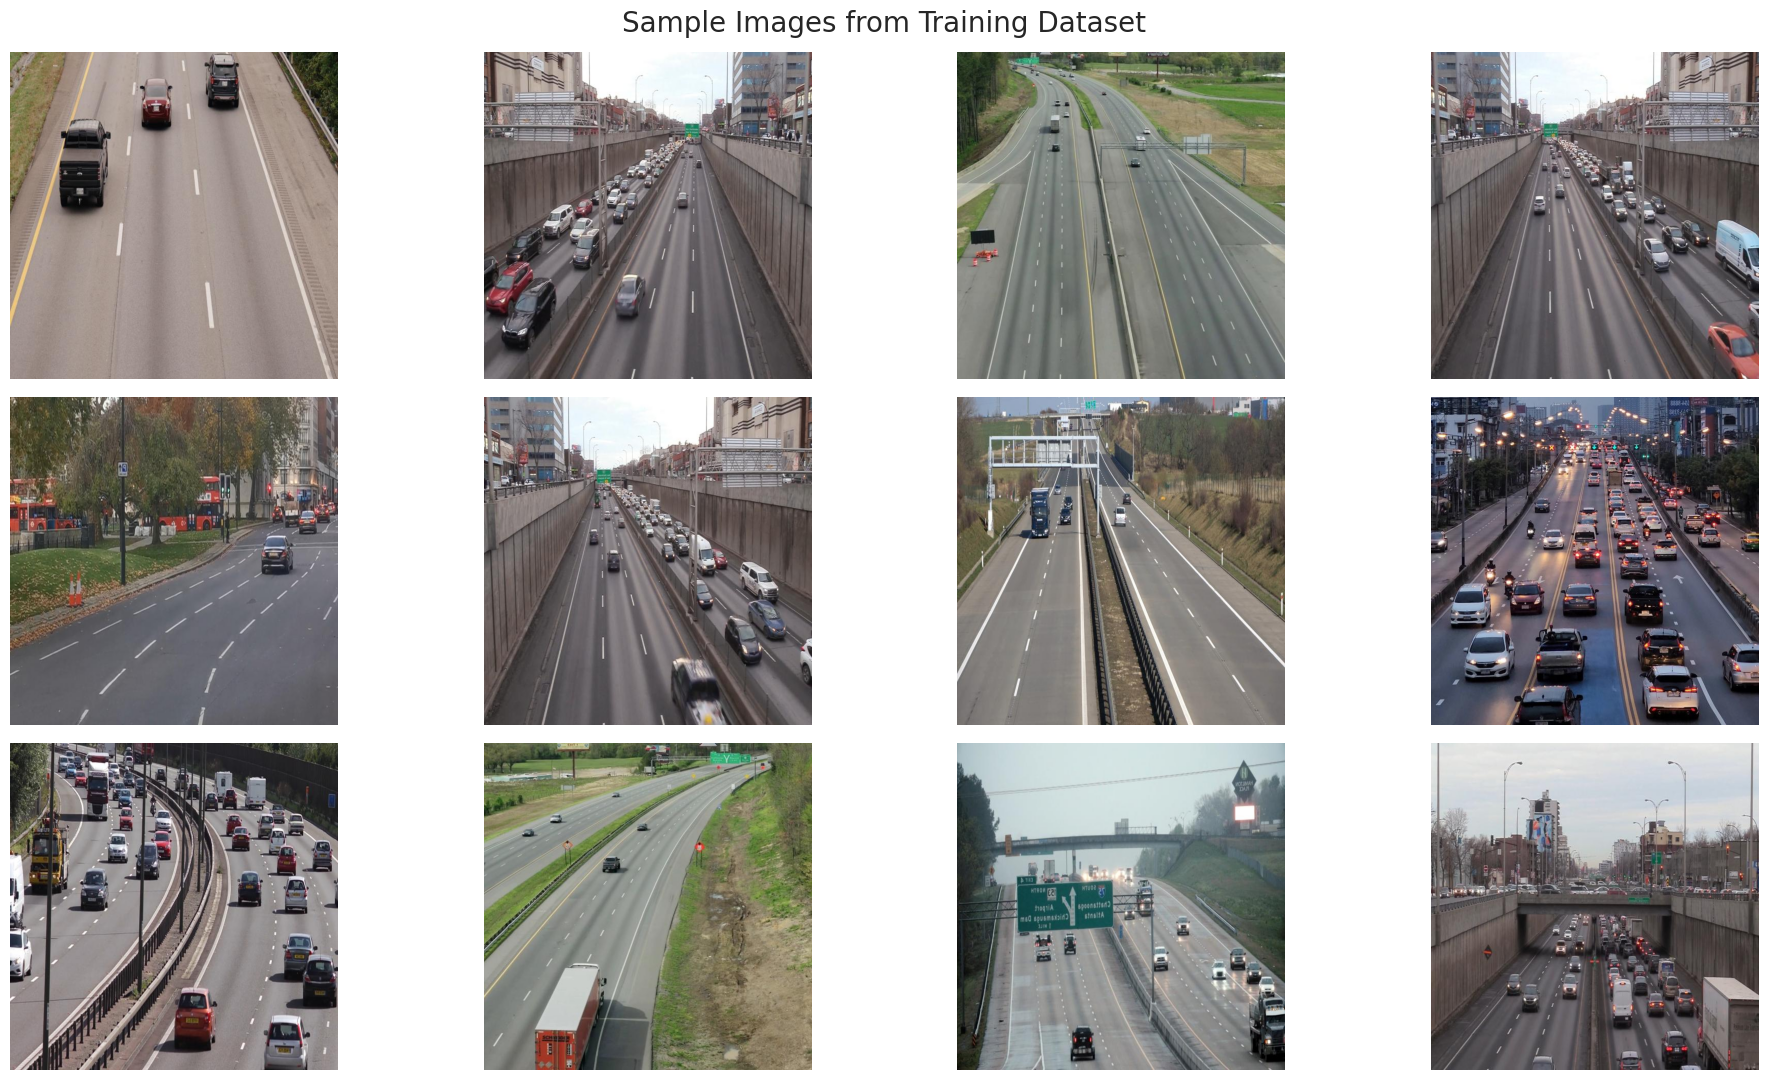

In [9]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 12)]

# Create a 2x4 subplot
fig, axes = plt.subplots(3, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')  

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

# Yolo Models Finetuning 

In [10]:
results_v8 = model_v8.train(
    data=yaml_file_path,     
    epochs=100,              
    imgsz=640,               
    device=0,                 
    patience=5,             
    batch=32,                
    optimizer='Adam'                                       
)

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:01<00:00, 312.50it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 302.71it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.22G      2.086      2.416      1.568        311        640: 100%|██████████| 17/17 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


                   all         90        937    0.00285     0.0822     0.0016    0.00053

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.31G      1.316     0.9974      1.079        294        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         90        937      0.138      0.063      0.077     0.0525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.87G      1.249     0.8718       1.05        321        640: 100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         90        937     0.0886      0.492     0.0827     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.76G      1.229     0.8524      1.051        419        640: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         90        937      0.206      0.672      0.192      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.77G      1.212     0.8093      1.038        371        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         90        937       0.74      0.823      0.842      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.73G      1.211     0.8027      1.031        289        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         90        937      0.789      0.867      0.864      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.46G      1.185      0.755      1.026        433        640: 100%|██████████| 17/17 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.824      0.899      0.918      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.1G      1.154     0.7243      1.025        357        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.848      0.846       0.88      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         5G      1.112      0.697      1.009        333        640: 100%|██████████| 17/17 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         90        937      0.797      0.832      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.48G      1.143     0.7006      1.009        250        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         90        937      0.858      0.877      0.932      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.41G      1.123     0.6986      1.015        335        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.856      0.881      0.927      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.83G      1.118     0.6645      1.009        404        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.739      0.838      0.802       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.87G      1.134     0.7155      1.014        341        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.861      0.853      0.933      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.09G       1.13     0.6954      1.015        247        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         90        937      0.847      0.902      0.935      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.87G      1.106     0.6797      1.003        420        640: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         90        937      0.848      0.878      0.936      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.71G      1.107     0.6567      1.002        346        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         90        937      0.853      0.865      0.937      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.84G        1.1     0.6583      1.001        403        640: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         90        937      0.787      0.925      0.884      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.76G      1.092     0.6505     0.9896        384        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         90        937       0.89      0.899      0.948      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.24G      1.093     0.6564      1.002        299        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         90        937      0.884      0.884      0.945      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.92G      1.101     0.6609      1.004        362        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         90        937      0.888      0.888      0.955      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.88G      1.076     0.6485     0.9974        294        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.889      0.899      0.959      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.42G      1.095     0.6408      1.006        316        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         90        937      0.789       0.87      0.848      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.72G      1.084     0.6467      1.006        326        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         90        937      0.898      0.886      0.951      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.14G       1.08     0.6266     0.9958        371        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         90        937      0.886       0.89       0.95      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.16G      1.077      0.637          1        385        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         90        937      0.865      0.896      0.949       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.93G       1.06     0.6114     0.9888        285        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         90        937      0.874      0.922      0.956      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.87G      1.053     0.6171     0.9816        398        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         90        937      0.874      0.895      0.956      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.13G      1.032      0.608     0.9844        291        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         90        937      0.857       0.91       0.95      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.19G      1.055     0.6097     0.9899        337        640: 100%|██████████| 17/17 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         90        937       0.86      0.914      0.943      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.55G      1.055     0.6111     0.9768        334        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         90        937      0.896      0.914      0.957      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.77G      1.037     0.5972     0.9828        370        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         90        937      0.864      0.917      0.953      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.71G      1.068     0.5975     0.9842        333        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         90        937      0.875      0.919       0.96      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.54G      1.034     0.5991     0.9762        364        640: 100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         90        937      0.839      0.912      0.946       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.29G      1.056     0.6038     0.9837        323        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         90        937      0.906      0.908      0.967        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.96G      1.029     0.5853      0.976        416        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         90        937      0.909      0.909      0.965      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       5.2G      1.033     0.5787     0.9814        330        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.887      0.925      0.964      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.95G      1.016     0.5775     0.9711        293        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         90        937      0.882      0.906      0.958        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.65G      1.021     0.5879     0.9768        385        640: 100%|██████████| 17/17 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         90        937      0.902      0.914      0.967      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.05G      1.031     0.5974     0.9768        503        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.893      0.923       0.96       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.65G      1.014     0.5718     0.9807        321        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         90        937        0.9      0.882      0.958      0.691
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.075 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


                   all         90        937      0.908      0.909      0.964      0.705
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [11]:
results_v11 = model_v11.train(
    data=yaml_file_path,     
    epochs=100,              
    imgsz=640,               
    device=0,                 
    patience=5,             
    batch=32,                
    optimizer='Adam'                                       
)

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<00:00, 790.90it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 648.16it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.68G      2.373      2.778       1.78        311        640: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         90        937    0.00278       0.08    0.00181   0.000412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.79G      1.337      1.082      1.096        294        640: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


                   all         90        937      0.154      0.759      0.513      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.45G      1.286     0.9109      1.068        321        640: 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         90        937      0.743      0.589      0.699      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.34G      1.227      0.833      1.055        419        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all         90        937      0.803      0.794       0.87      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.35G      1.197     0.8062      1.042        371        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         90        937      0.792      0.789      0.835      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.11G      1.204     0.7966      1.036        289        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


                   all         90        937       0.82      0.856      0.886      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.04G      1.167     0.7461      1.024        433        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         90        937      0.788      0.887      0.852      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.68G      1.141     0.7154      1.018        357        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         90        937      0.863      0.872      0.937      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.58G      1.124     0.6917      1.012        333        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         90        937       0.84      0.889      0.926      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.35G      1.142     0.6933      1.013        250        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         90        937      0.875      0.864      0.939      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.6G      1.134     0.6774       1.02        335        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         90        937      0.889       0.86      0.937      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.41G      1.124     0.6636      1.012        404        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         90        937      0.862      0.877      0.938      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.45G      1.136     0.7084      1.012        341        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         90        937      0.857      0.875      0.935      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.67G      1.122     0.6773      1.013        247        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         90        937      0.867      0.882      0.952      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.38G      1.111      0.674       1.01        420        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         90        937      0.852        0.9      0.947       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.18G      1.107     0.6573      1.007        346        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         90        937      0.886       0.86      0.934      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.36G      1.103     0.6521      1.006        403        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         90        937      0.909      0.901      0.963      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.34G        1.1     0.6574     0.9899        384        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         90        937       0.86      0.827      0.901      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.82G      1.105     0.6596      1.003        299        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         90        937      0.867      0.882      0.949       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.51G      1.103      0.645      1.005        362        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


                   all         90        937      0.894      0.901      0.961      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.44G       1.08     0.6369     0.9957        294        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         90        937      0.903      0.889      0.956      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         5G      1.106     0.6427      1.001        316        640: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         90        937      0.875        0.9      0.946      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.48G      1.095     0.6384      1.006        326        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         90        937      0.917      0.879      0.963      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.72G       1.09     0.6247     0.9957        371        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.876      0.922      0.962      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.74G      1.061     0.6281     0.9966        385        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         90        937      0.886      0.875      0.953      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.43G      1.068     0.6205     0.9865        285        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.866      0.922      0.951      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.44G      1.057      0.631     0.9837        398        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         90        937      0.874      0.882      0.949       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.62G      1.044     0.6092     0.9831        291        640: 100%|██████████| 17/17 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.856      0.885      0.941      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.77G      1.065     0.6188     0.9924        337        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         90        937      0.872      0.884      0.944      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       5.3G      1.065     0.6246     0.9779        334        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         90        937      0.916      0.874      0.963      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.35G       1.06     0.6035      0.988        370        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.914      0.887      0.962      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.23G      1.076      0.607     0.9905        333        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         90        937      0.921       0.87      0.959      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.12G      1.047     0.6023     0.9803        364        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         90        937      0.913      0.879      0.958      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.13G      1.072     0.6121     0.9903        323        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         90        937      0.874      0.911       0.96      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.54G      1.035     0.5889     0.9733        416        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         90        937      0.894      0.908      0.962      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.78G      1.051     0.5904      0.979        330        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         90        937      0.907      0.905      0.966      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.53G      1.023     0.5858     0.9684        293        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         90        937       0.89      0.918      0.964      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.04G      1.033      0.589     0.9743        385        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         90        937      0.897       0.92      0.963      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.62G      1.038     0.5986     0.9776        503        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         90        937        0.9      0.888      0.962      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.23G      1.015      0.577     0.9774        321        640: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         90        937        0.9      0.894      0.954      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.09G      1.041      0.587     0.9839        284        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         90        937      0.888      0.896      0.953      0.685
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.082 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         90        937      0.907      0.905      0.966      0.709
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2


# Comapring Performance 

In [12]:
# Define the path to the directory
post_training_files_path_v8 = '/kaggle/working/runs/detect/train'
post_training_files_path_v11 = '/kaggle/working/runs/detect/train'

# List the files in the directory
!ls {post_training_files_path_v8}
!ls {post_training_files_path_v11}

args.yaml					  results.csv
confusion_matrix_normalized.png			  results.png
confusion_matrix.png				  train_batch0.jpg
events.out.tfevents.1737899020.569d8554dd3d.18.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  weights
args.yaml					  results.csv
confusion_matrix_normalized.png			  results.png
confusion_matrix.png				  train_batch0.jpg
events.out.tfevents.1737899020.569d8554dd3d.18.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  weights


In [13]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **Learning Curves**

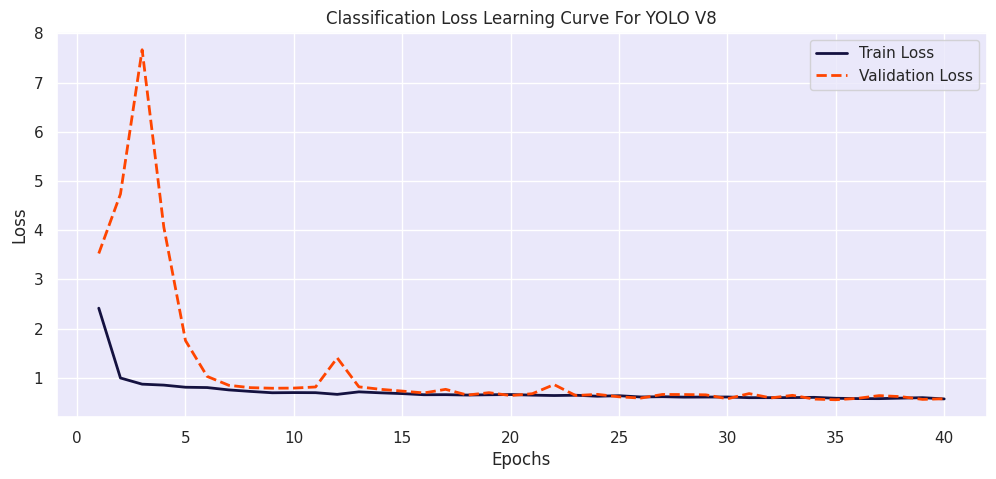

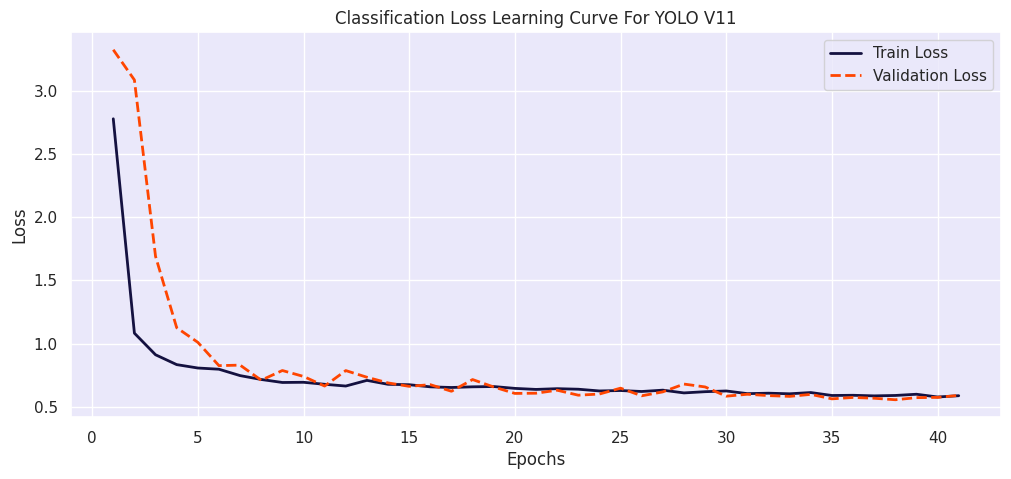

In [14]:
#Create the full file path for 'results.csv' using the directory path and file name
results_csv_path_v8 = os.path.join(post_training_files_path_v8, '/kaggle/working/runs/detect/train/results.csv')
results_csv_path_v11 = os.path.join(post_training_files_path_v11, '/kaggle/working/runs/detect/train2/results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df_v8 = pd.read_csv(results_csv_path_v8)
df_v11 = pd.read_csv(results_csv_path_v11)

# Remove any leading whitespace from the column names
df_v8.columns = df_v8.columns.str.strip()
df_v11.columns = df_v11.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df_v8, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve For YOLO V8')
plot_learning_curve(df_v11, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve For YOLO V11')

## **Confusion Matrix**

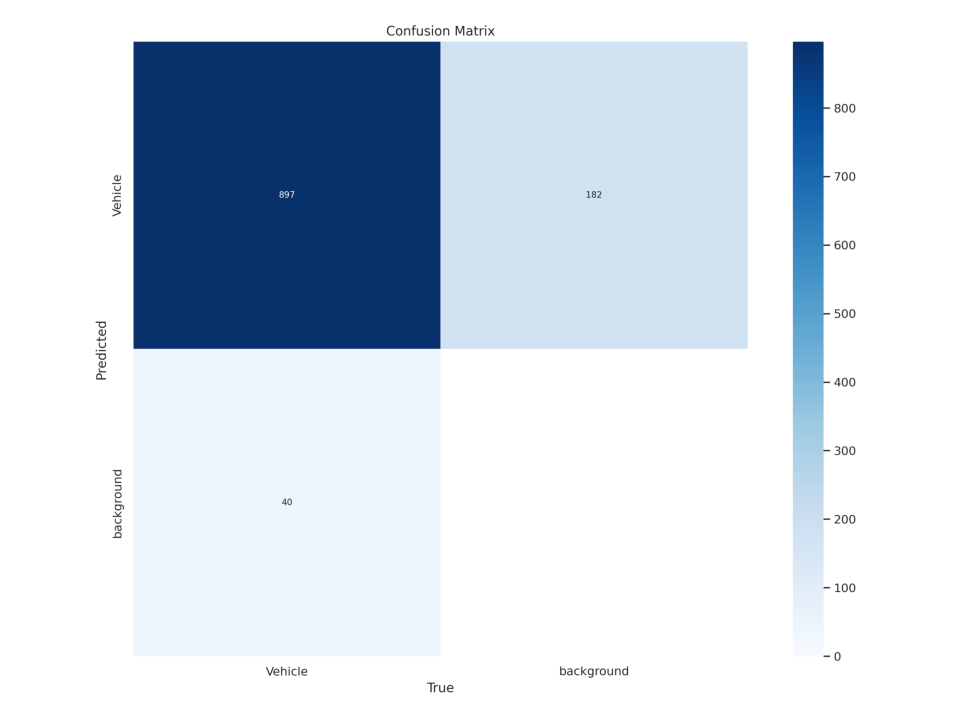

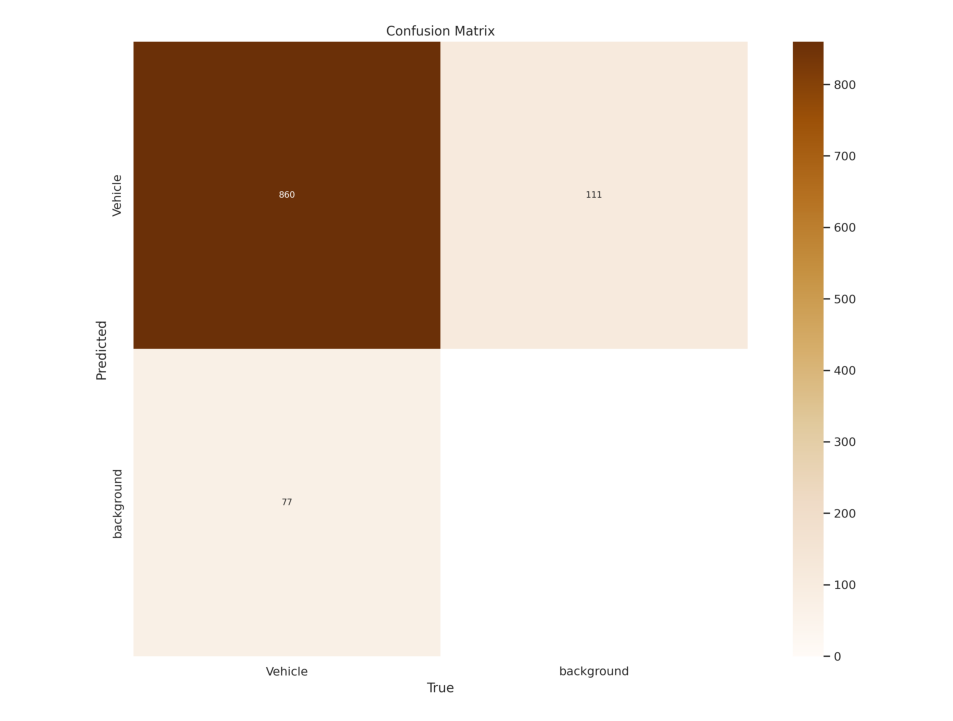

In [15]:
confusion_matrix_path_v8 = os.path.join(post_training_files_path_v8, '/kaggle/working/runs/detect/train/confusion_matrix.png')
confusion_matrix_path_v11 = os.path.join(post_training_files_path_v11, '/kaggle/working/runs/detect/train2/confusion_matrix.png')

cm_img_v8 = cv2.imread(confusion_matrix_path_v8)
cm_img_v8 = cv2.cvtColor(cm_img_v8, cv2.COLOR_BGR2RGB)

cm_img_v11 = cv2.imread(confusion_matrix_path_v11)
cm_img_11 = cv2.cvtColor(cm_img_v11, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img_v8)
plt.axis('off') 
plt.show()

plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img_v11)
plt.axis('off') 
plt.show()

## **Metrics**

In [16]:
best_model_path_v8 = os.path.join(post_training_files_path_v8, '/kaggle/working/runs/detect/train/weights/best.pt')
best_model_path_v11 = os.path.join(post_training_files_path_v11, '/kaggle/working/runs/detect/train2/weights/best.pt')

best_model_v8 = YOLO(best_model_path_v8)
best_model_v11 = YOLO(best_model_path_v11)

metrics_v8 = best_model_v8.val(split='val')
print('--------------------------------------------------------------------')
metrics_v11 = best_model_v11.val(split='val')

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 731.37it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


                   all         90        937       0.91      0.905      0.965      0.706
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/val
--------------------------------------------------------------------
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 896.53it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


                   all         90        937      0.907      0.906      0.966      0.711
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to runs/detect/val2


In [17]:
metrics_df_v8 = pd.DataFrame.from_dict(metrics_v8.results_dict, orient='index', columns=['Metric Value YOLOV8'])
metrics_df_v8.round(3)

Metric Value YOLOV8
metrics/precision(B)                0.910
metrics/recall(B)                   0.905
metrics/mAP50(B)                    0.965
metrics/mAP50-95(B)                 0.706
fitness                             0.732

In [18]:
metrics_df_v11 = pd.DataFrame.from_dict(metrics_v11.results_dict, orient='index', columns=['Metric Value YOLOV11'])
metrics_df_v11.round(3)

Metric Value YOLOV11
metrics/precision(B)                 0.907
metrics/recall(B)                    0.906
metrics/mAP50(B)                     0.966
metrics/mAP50-95(B)                  0.711
fitness                              0.736

# Testing Models After Finetuning 


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 6 Vehicles, 35.5ms
Speed: 4.0ms preprocess, 35.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 Vehicles, 23.0ms
Speed: 1.8ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


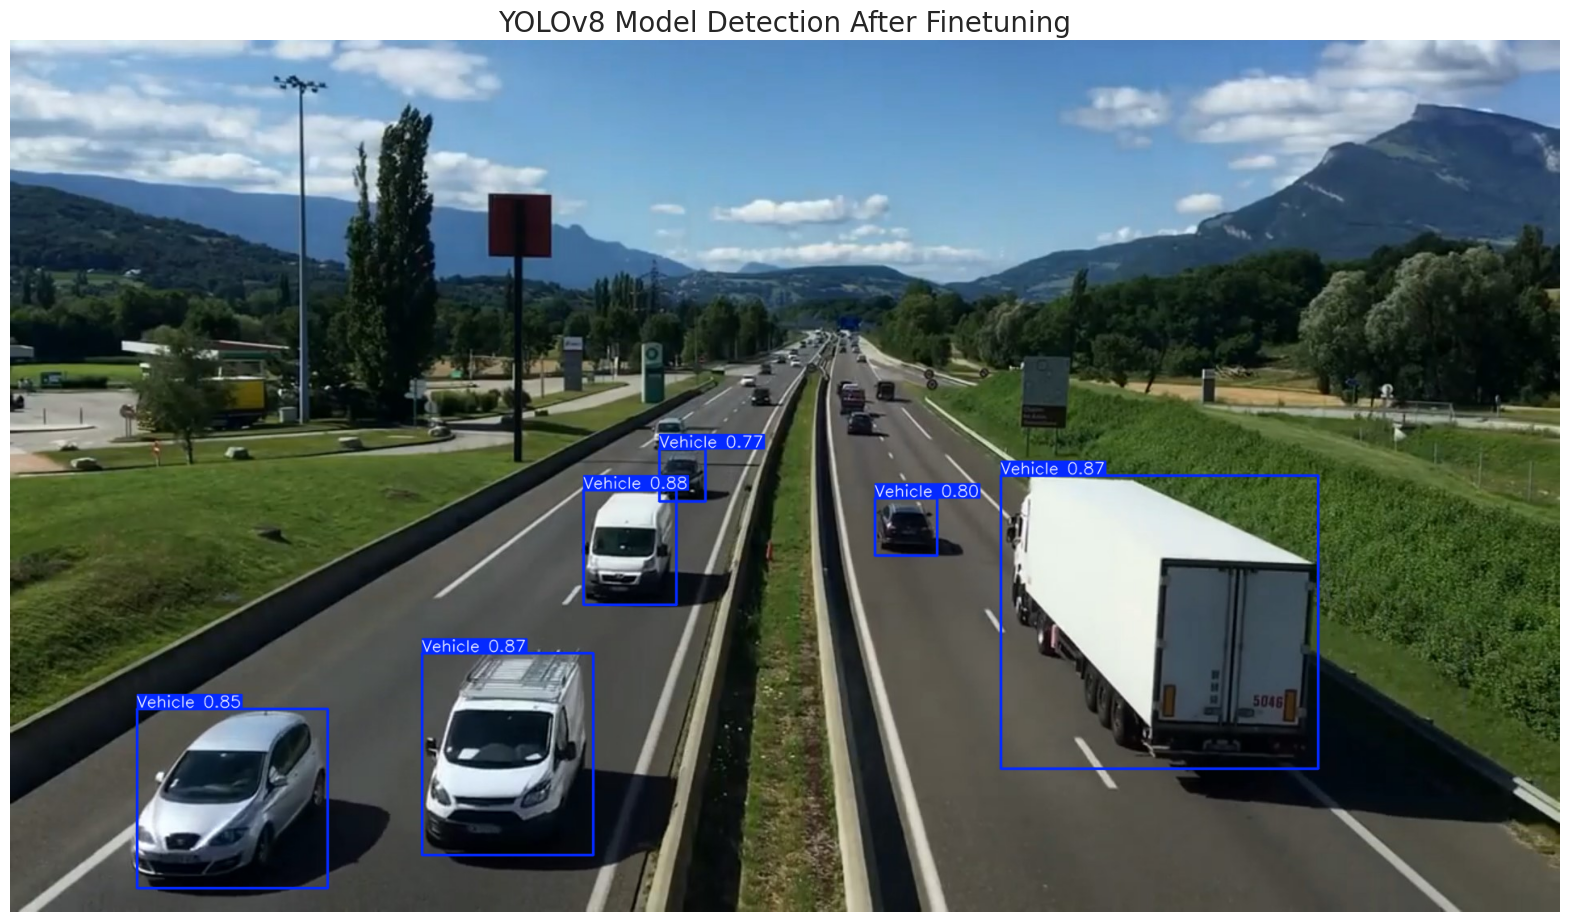

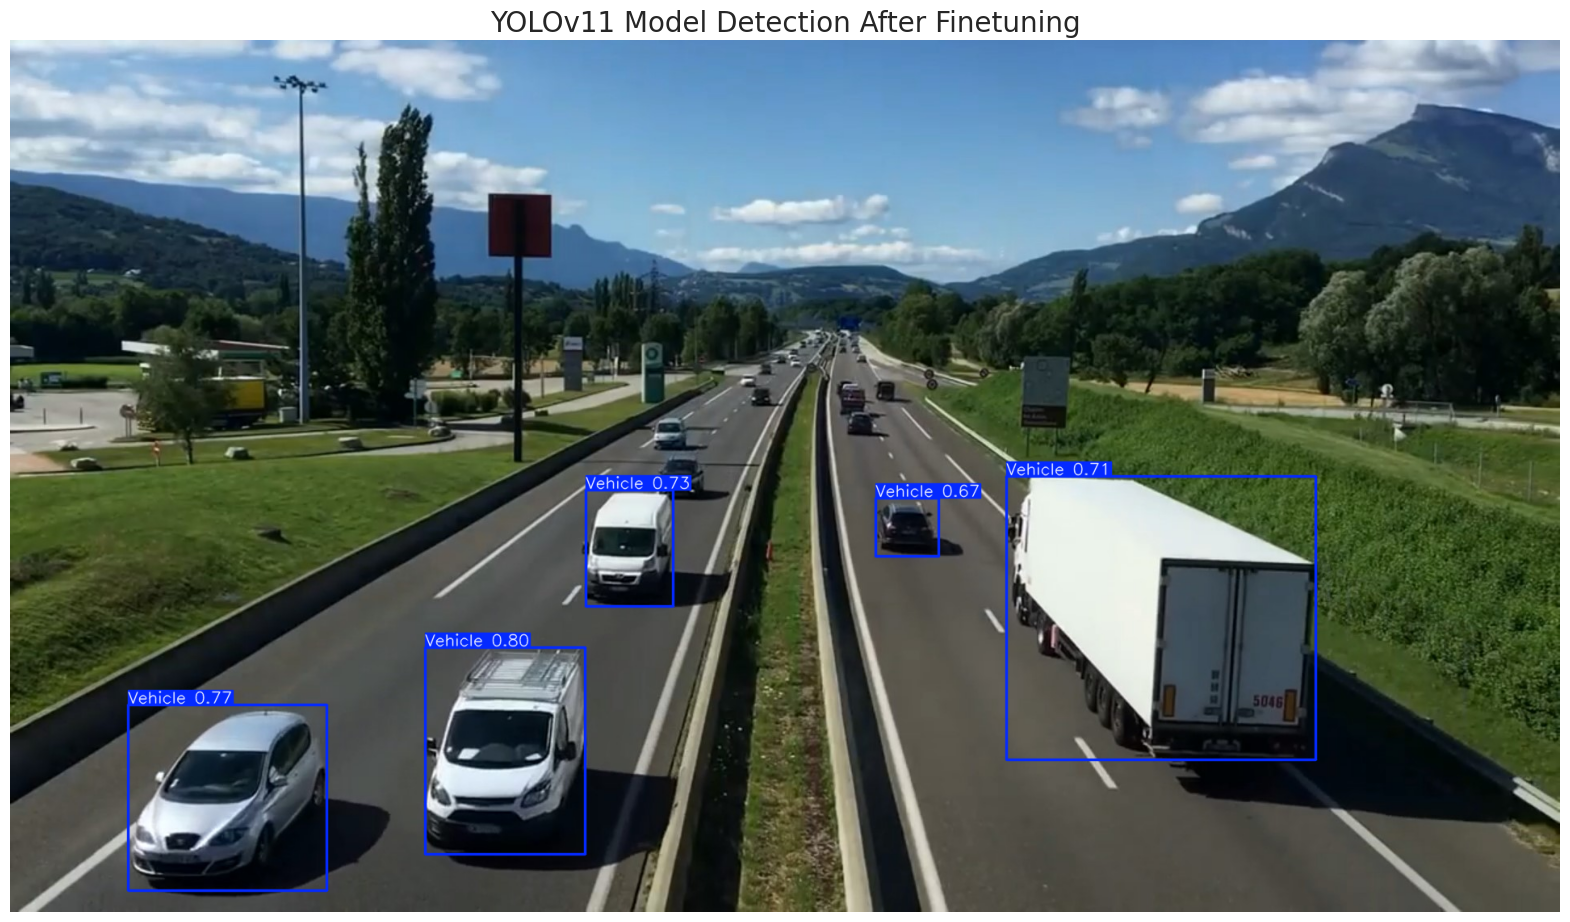

In [19]:
sample_image_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg'

result_v8 = best_model_v8.predict(source=sample_image_path, imgsz=640, conf=0.65)
result_v11 = best_model_v11.predict(source=sample_image_path, imgsz=640, conf=0.65) 
                        
sample_image_v8 = result_v8[0].plot(line_width=2)
sample_image_v11 = result_v11[0].plot(line_width=2)

sample_image_v8 = cv2.cvtColor(sample_image_v8, cv2.COLOR_BGR2RGB)
sample_image_v11 = cv2.cvtColor(sample_image_v11, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,15))
plt.imshow(sample_image_v8)
plt.title('YOLOv8 Model Detection After Finetuning', fontsize=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(20,15))
plt.imshow(sample_image_v11)
plt.title('YOLOv11 Model Detection After Finetuning', fontsize=20)
plt.axis('off')
plt.show()